### Data Analysis for Business, Economics, and Policy

### Chapter 09
**CH09A Estimating gender and age differences in earnings**

based on case-study repo, Chapter 09 and Chapter 08

using the cps-earnings dataset


In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer
import statsmodels.nonparametric.kernel_regression as loess

warnings.filterwarnings("ignore")


In [3]:
#data_all = pd.read_csv("morg-2014-emp.csv")
data_all = pd.read_csv("https://osf.io/download/4ay9x/")



### SELECT OCCUPATION

keep only two occupation types: Market research analysts and marketing specialists and Computer and Mathematical Occupations

In [3]:
data_all.loc[data_all["occ2012"] == 735, "sample"] = 1
data_all.loc[
    ((data_all["occ2012"] >= 1005) & (data_all["occ2012"] <= 1240)), "sample"
] = 2
data_all.loc[data_all["sample"].isna(), "sample"] = 0


In [4]:
# Redefine samples and show number of observations
data_all = data_all.loc[
    (data_all["sample"] == 1) | (data_all["sample"] == 2), :
].reset_index(drop=True)

data_all["sample"].value_counts()

sample
2.0    4740
1.0     281
Name: count, dtype: int64

In [5]:
# Create new variables
data_all["female"] = (data_all["sex"] == 2)
data_all["w"] = data_all["earnwke"] / data_all["uhours"]
data_all["lnw"] = np.log(data_all["w"])
data_all["agesq"] = np.power(data_all["age"], 2)


# Now we focus on market analyists and marketing professionals

In [6]:
# Change i to 2 if want to use the Computer Science sample
i = 1
data = data_all.loc[data_all["sample"] == i, :].reset_index(drop=True)


### DISTRIBUTION OF EARNINGS

In [7]:
data.loc[:, ["earnwke", "uhours", "w"]].describe()

,earnwke,uhours,w
count,281.000000,281.000000,281.000000
mean,1206.186940,40.153025,29.061656
std,709.545222,10.325838,14.712495
min,40.000000,5.000000,7.250000
25%,700.000000,40.000000,17.788250
50%,1096.150000,40.000000,25.950000
75%,1538.000000,40.000000,37.019000
max,2884.610000,80.000000,84.600000


In [8]:
# Number of femail in our sample
data["female"].value_counts()


female
True     172
False    109
Name: count, dtype: int64

### Linear regressions with female vs male earnings

In [9]:
# Classical -- heteroskedastic SE regression
reg1 = smf.ols(formula="lnw~female", data=data).fit()
reg1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     3.390
Date:                Mon, 11 Nov 2024   Prob (F-statistic):             0.0666
Time:                        10:10:42   Log-Likelihood:                -203.81
No. Observations:                 281   AIC:                             411.6
Df Residuals:                     279   BIC:                             418.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.3149      0.048     69.004      0.000       3.220       3.409
female[T.True]    -0.1131      0.061     -1.841      0.067      -0.234       0.008
==============================================================================
Omnibus:                        5.253   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.072   Jarque-Bera (JB):                3.371
Skew:                          -0.070   Prob(JB):                        0.185
Kurtosis:                       2.482   Cond. No.                         2.97
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
# Heteroskedastic (White-Huber)
reg2 = smf.ols(formula="lnw~female", data=data).fit(cov_type="HC1")
reg2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     3.347
Date:                Mon, 11 Nov 2024   Prob (F-statistic):             0.0684
Time:                        10:10:42   Log-Likelihood:                -203.81
No. Observations:                 281   AIC:                             411.6
Df Residuals:                     279   BIC:                             418.9
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.3149      0.049     67.810      0.000       3.219       3.411
female[T.True]    -0.1131      0.062     -1.829      0.067      -0.234       0.008
==============================================================================
Omnibus:                        5.253   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.072   Jarque-Bera (JB):                3.371
Skew:                          -0.070   Prob(JB):                        0.185
Kurtosis:                       2.482   Cond. No.                         2.97
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

### Table 9.1 Wage and gender gap baseline regression

In [11]:
stargazer = Stargazer([reg1, reg2])
stargazer.covariate_order(["female[T.True]", "Intercept"])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer


## Investigating the age pattern

In [12]:
reg3 = smf.ols(formula="lnw~age", data=data).fit(cov_type="HC1")
reg3.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     26.36
Date:                Mon, 11 Nov 2024   Prob (F-statistic):           5.31e-07
Time:                        10:10:42   Log-Likelihood:                -191.01
No. Observations:                 281   AIC:                             386.0
Df Residuals:                     279   BIC:                             393.3
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7317      0.101     27.006      0.000       2.533       2.930
age            0.0135      0.003      5.135      0.000       0.008       0.019
==============================================================================
Omnibus:                        1.782   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.410   Jarque-Bera (JB):                1.708
Skew:                          -0.109   Prob(JB):                        0.426
Kurtosis:                       2.687   Cond. No.                         136.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

### Confidence interval, prediction interval.

(a) Confidence interval of the regression line

In [13]:
pred_confidence = data.join(
    pd.DataFrame(reg3.get_prediction().conf_int(), columns=["lwr", "upr"])
).join(reg3.get_prediction().summary_frame()["mean"].rename("fit"))

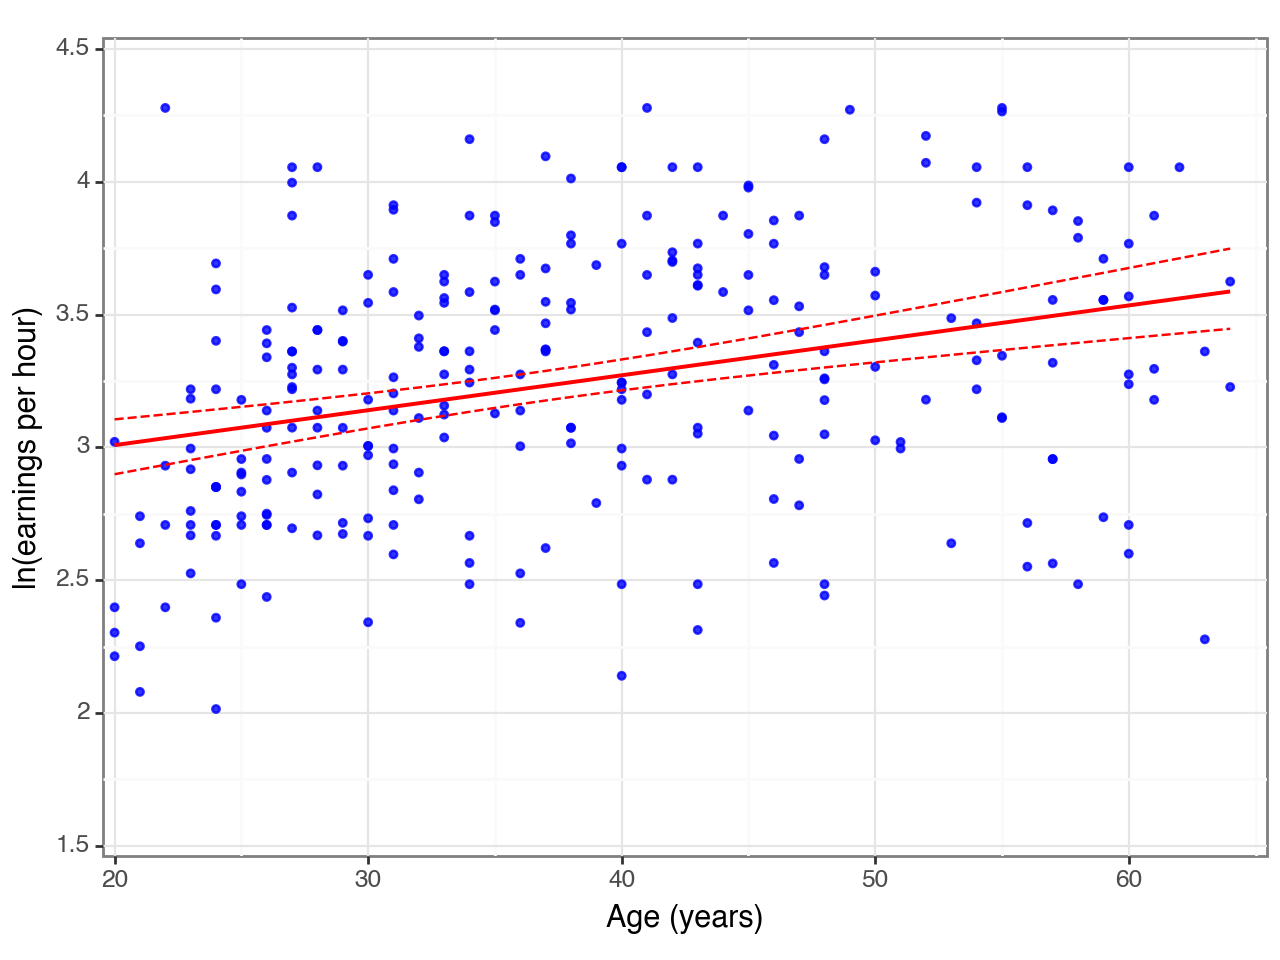

<Figure Size: (640 x 480)>

In [14]:
(
    ggplot(
        pred_confidence.loc[lambda x: (x["lnw"] < 4.4) & (x["lnw"] > 2)],
        aes(x="age", y="lnw"),
    )
    + geom_point(color='blue', size=1, alpha=0.8, show_legend=False, na_rm=True)
    + geom_smooth(method="lm", colour='red', se=False, size=0.8, linetype="solid")
    + geom_line(
        pred_confidence,
        aes(x="age", y="lwr"),
        size=0.5,
        linetype="dashed",
        colour='red',
    )
    + geom_line(
        pred_confidence,
        aes(x="age", y="upr"),
        size=0.5,
        linetype="dashed",
        colour='red',
    )
    + coord_cartesian(xlim=(20, 65), ylim=(1.5, 4.5))
    + scale_x_continuous(expand=(0.01, 0.01), limits=(20, 65))#, breaks=seq(20, 65, by=5))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(1.5, 4.5)#, breaks=seq(1.5, 4.5, by=0.50)
    )
    + labs(x="Age (years)", y="ln(earnings per hour)")
    + scale_linetype_manual(
        name="",
        values=(1, 1, 2),
        labels=("Lowess", "Confidence interval (95%)", "Confidence interval (95%)"),
    )
    + theme_bw()
)


(b) Prediction interval of the observations

In [15]:
pred_interval = data
pred_interval[["lwr", "upr"]] = (
    reg3.get_prediction().summary_frame().loc[:, ["obs_ci_lower", "obs_ci_upper"]]
)
pred_interval = pred_interval.join(
    reg3.get_prediction().summary_frame()["mean"].rename("fit")
)


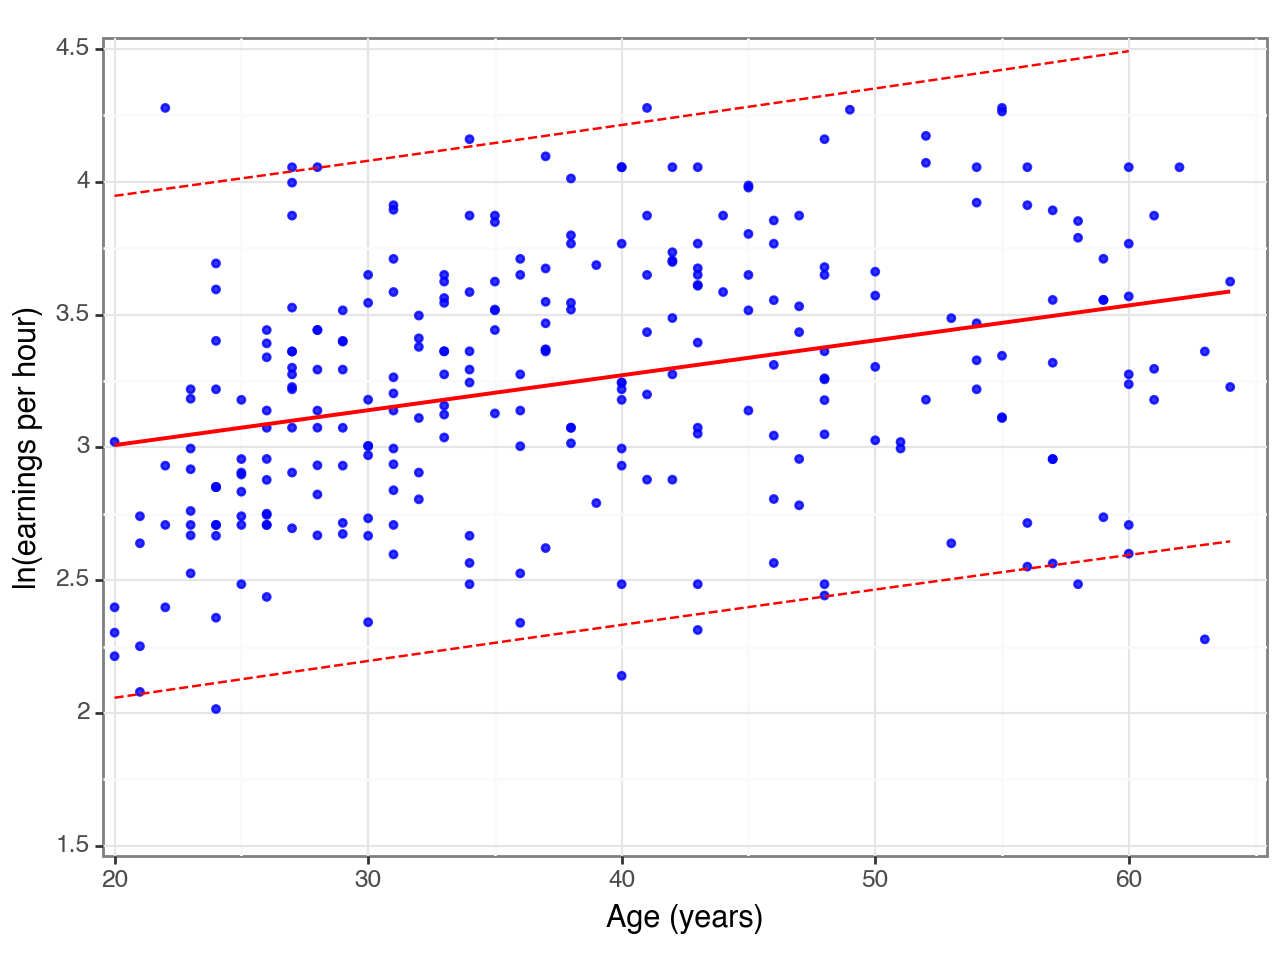

<Figure Size: (640 x 480)>

In [16]:
(
    ggplot(
        pred_interval.loc[lambda x: (x["lnw"] < 4.4) & (x["lnw"] > 2)],
        aes(x="age", y="lnw"),
    )
    + geom_point(color='blue', size=1, alpha=0.8, show_legend=False, na_rm=True)
    + geom_smooth(method="lm", colour='red', se=False, size=0.8, linetype="solid")
    + geom_line(
        pred_interval, aes(y="lwr"), size=0.5, linetype="dashed", colour='red'
    )
    + geom_line(
        pred_interval, aes(y="upr"), size=0.5, linetype="dashed", colour='red'
    )
    + coord_cartesian(xlim=(20, 65), ylim=(1.5, 4.5))
    + scale_x_continuous(expand=(0.01, 0.01), limits=(20, 65))#, breaks=seq(20, 65, by=5))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(1.5, 4.5)#, breaks=seq(1.5, 4.5, by=0.50)
    )
    + labs(x="Age (years)", y="ln(earnings per hour)")
    + theme_bw()
)


## Non-linear patterns

### Log hourly wage and age: regressions that capture nonlinearity

(a) Lowess regression and scatterplot

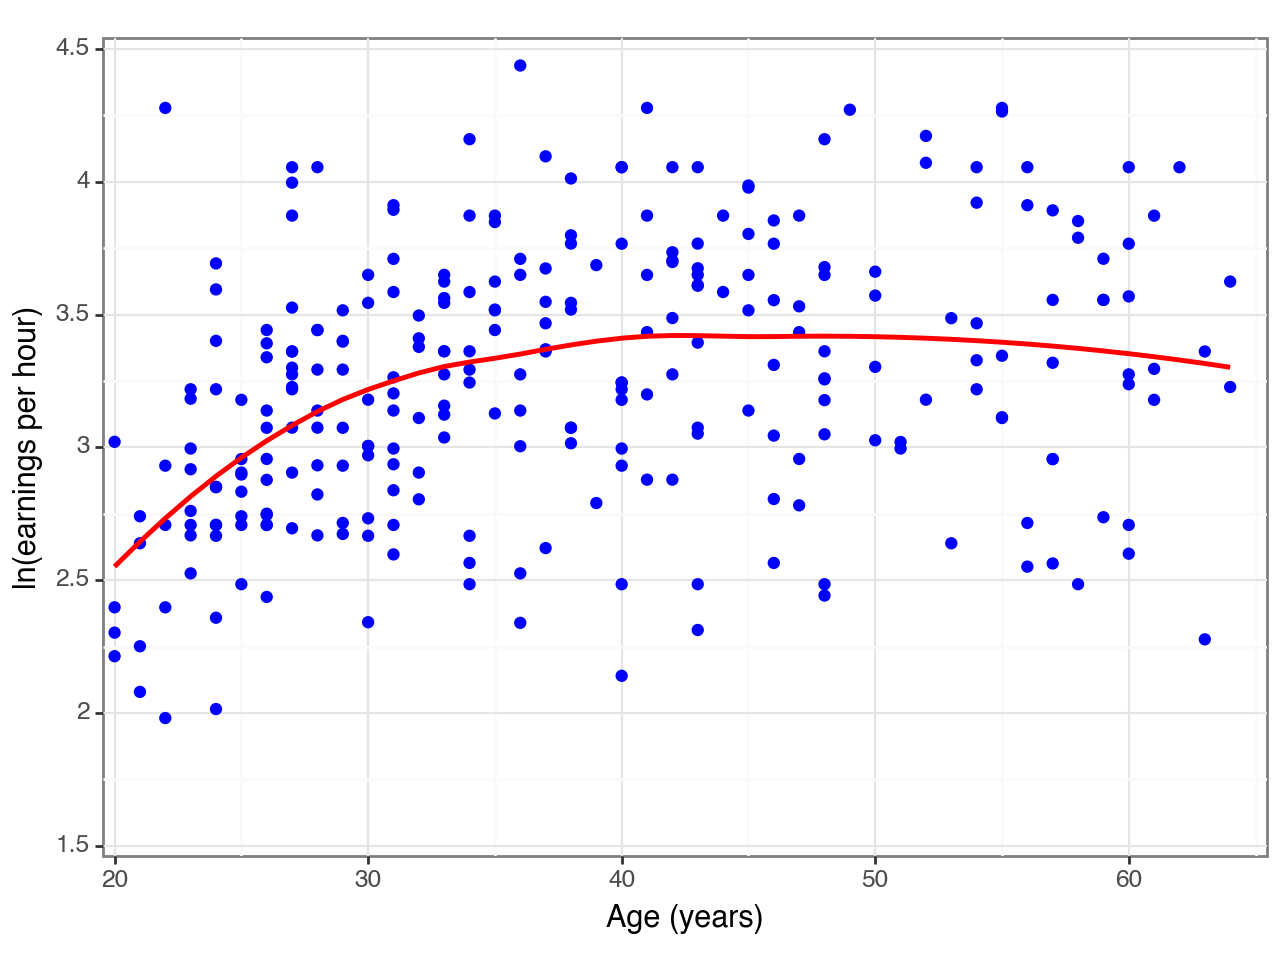

<Figure Size: (640 x 480)>

In [17]:
(
    ggplot(data, aes(x="age", y="lnw"))
    + geom_point(color='blue')
    + geom_smooth(method="loess", color='red', se=False)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(20, 65))#, breaks=seq(20, 65, by=5))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(1.5, 4.5)#, breaks=seq(1.5, 4.5, by=0.50)
    )
    + labs(x="Age (years)", y="ln(earnings per hour)")
    + theme_bw()
)


#### 1) non-linear pattern: simple quadratic form

In [18]:
reg4 = smf.ols(formula="lnw~age+agesq", data=data).fit(cov_type="HC1")
reg4.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     27.47
Date:                Mon, 11 Nov 2024   Prob (F-statistic):           1.29e-11
Time:                        10:10:43   Log-Likelihood:                -179.58
No. Observations:                 281   AIC:                             365.2
Df Residuals:                     278   BIC:                             376.1
Df Model:                           2                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1935      0.341      3.499      0.000       0.525       1.862
age            0.0962      0.018      5.360      0.000       0.061       0.131
agesq         -0.0010      0.000     -4.608      0.000      -0.001      -0.001
==============================================================================
Omnibus:                        0.304   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.859   Jarque-Bera (JB):                0.353
Skew:                          -0.078   Prob(JB):                        0.838
Kurtosis:                       2.924   Cond. No.                     2.22e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 2.22e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 2) Piecewise linear spline

In [19]:
import copy
def lspline(series, knots):
    def knot_ceil(vector, knot):
        vector_copy = copy.deepcopy(vector)
        vector_copy[vector_copy > knot] = knot
        return vector_copy

    if type(knots) != list:
        knots = [knots]
    design_matrix = None
    vector = series.values

    for i in range(len(knots)):
        # print(i)
        # print(vector)
        if i == 0:
            column = knot_ceil(vector, knots[i])
        else:
            column = knot_ceil(vector, knots[i] - knots[i - 1])
        # print(column)
        if i == 0:
            design_matrix = column
        else:
            design_matrix = np.column_stack((design_matrix, column))
        # print(design_matrix)
        vector = vector - column
    design_matrix = np.column_stack((design_matrix, vector))
    # print(design_matrix)
    return design_matrix

We use theory and data to select knots: 30 yo and 40 yo workers

In [20]:
reg5 = smf.ols(formula="lnw~lspline(age,[30,40])", data=data).fit(cov_type="HC1")
reg5.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     19.33
Date:                Mon, 11 Nov 2024   Prob (F-statistic):           2.07e-11
Time:                        10:10:43   Log-Likelihood:                -178.88
No. Observations:                 281   AIC:                             365.8
Df Residuals:                     277   BIC:                             380.3
Df Model:                           3                                         
Covariance Type:                  HC1                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     1.3834      0.369      3.753      0.000       0.661       2.106
lspline(age, [30, 40])[0]     0.0624      0.014      4.559      0.000       0.036       0.089
lspline(age, [30, 40])[1]     0.0165      0.010      1.680      0.093      -0.003       0.036
lspline(age, [30, 40])[2]    -0.0026      0.006     -0.444      0.657      -0.014       0.009
==============================================================================
Omnibus:                        0.184   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.912   Jarque-Bera (JB):                0.147
Skew:                          -0.056   Prob(JB):                        0.929
Kurtosis:                       2.991   Cond. No.                         410.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

### Wage and age – different specifications

In [21]:
stargazer = Stargazer([reg3, reg4, reg5])
stargazer.covariate_order(
    [
        "age",
        "agesq",
        "lspline(age, [30, 40])[0]",
        "lspline(age, [30, 40])[1]",
        "lspline(age, [30, 40])[2]",
        "Intercept",
    ]
)
stargazer.rename_covariates(
    {
        "Intercept": "Constant",
        "agesq": "age squared",
        "lspline(age, [30, 40])[0]": "age spline <30",
        "lspline(age, [30, 40])[1]": "age spline 30–40",
        "lspline(age, [30, 40])[2]": "age spline 40<",
    }
)
stargazer


## Confidence interval of the regression line with non-linear models

### Estimate quadratic regression line for plotting

In [22]:
z = reg4.get_prediction().conf_int()
res = reg4.get_prediction().summary_frame()
data["lnwpred_ageq"] = res["mean"]
data["lnwpred_ageqCIUP"] = [x[0] for x in z]
data["lnwpred_ageqCILO"] = [x[1] for x in z]


### Estimate PLS regression line for plotting

In [23]:
z = reg5.get_prediction().conf_int()
res = reg5.get_prediction().summary_frame()
data["lnwpred_agesp"] = res["mean"]
data["lnwpred_agespCIUP"] = [x[0] for x in z]
data["lnwpred_agespCILO"] = [x[1] for x in z]


### Estimate lo(w)ess regression line for plotting

In [24]:
reg6 = loess.KernelReg(data["lnw"], data["age"], var_type="c", reg_type="lc")
data["lnwpred_agel"] = reg6.fit()[0]


#### Put them together Lowess, piecewise linear spline, and quadratic

In [25]:
plotdata = data.filter(["age", "lnwpred_agel", "lnwpred_ageq", "lnwpred_agesp"]).melt(
    id_vars=["age"]
)

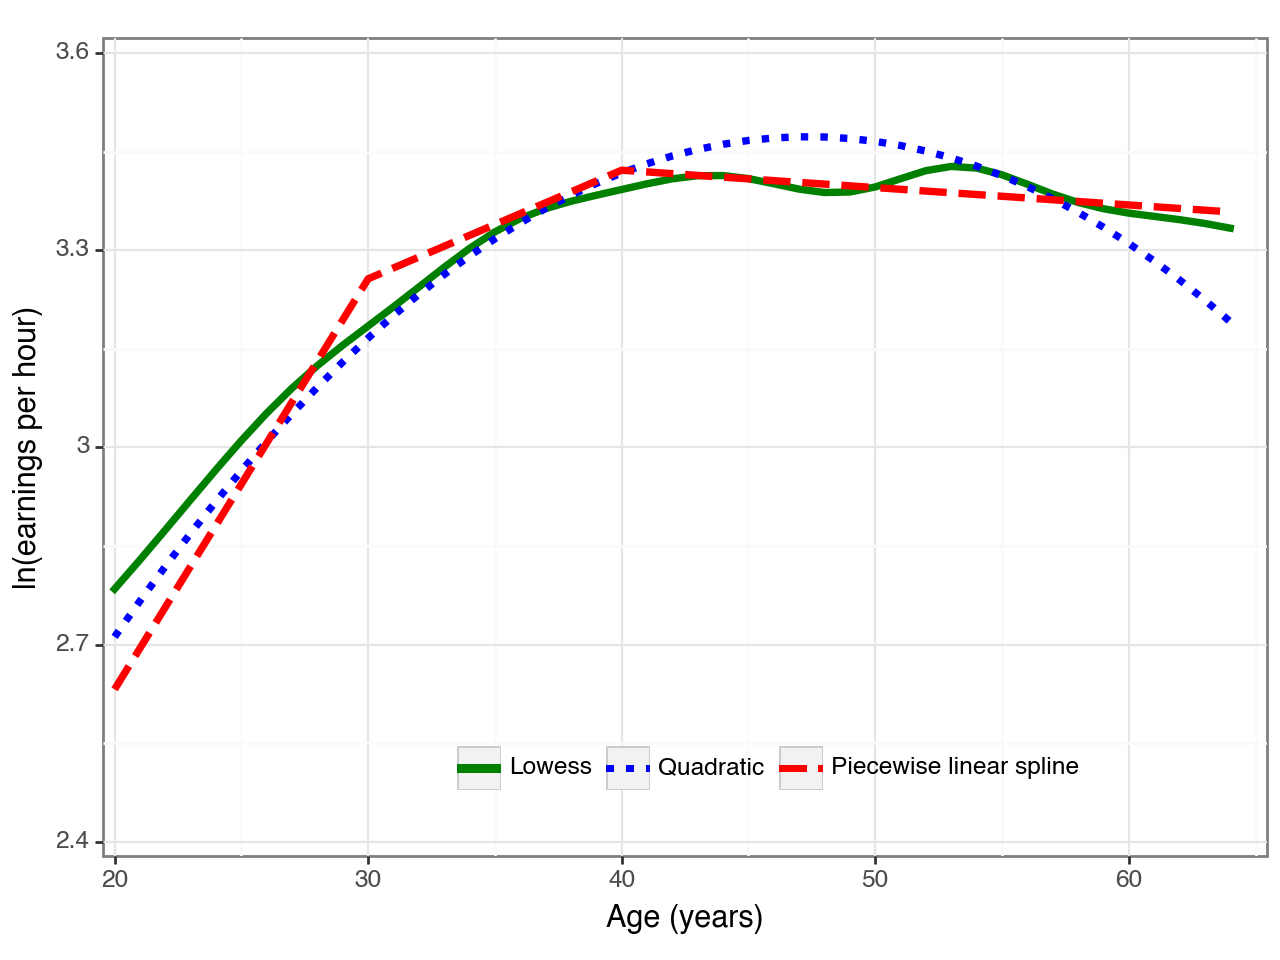

<Figure Size: (640 x 480)>

In [26]:
(
    ggplot(
        plotdata,
        aes(x="age", y="value", color="variable", linetype="variable"),
    )
    + geom_line(size=1.5)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(20, 65))#, breaks=seq(20, 66, by=5))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(2.4, 3.6)#, breaks=seq(2.4, 3.6, by=0.20)
    )
    + scale_color_manual(
        values=['green', 'blue', 'red'],
        labels=["Lowess", "Quadratic", "Piecewise linear spline"],
    )
    + scale_linetype_manual(
        values=["-", ":", "dashed"],
        labels=["Lowess", "Quadratic", "Piecewise linear spline"],
    )
    + labs(x="Age (years)", y="ln(earnings per hour)")
    + theme_bw()
    + theme(
        legend_position=(0.6, 0.2),
        legend_direction="horizontal",
        legend_title=element_blank(),
        legend_background=element_blank(),
    )
)

### Average log earnings and age: regressions with CI

In [27]:
plotdata = (
    data.filter(
        [
            "age",
            "lnwpred_agel",
            "lnwpred_ageq",
            "lnwpred_agesp",
            "lnwpred_ageqCIUP",
            "lnwpred_ageqCILO",
            "lnwpred_agespCIUP",
            "lnwpred_agespCILO",
        ]
    )
    .melt(id_vars=["age"])
    .assign(CI=lambda x: x["variable"].str.contains("CI"))
    .assign(
        estimate=lambda x: np.where(x["CI"], x["variable"].str[:-4], x["variable"]),
    )
)

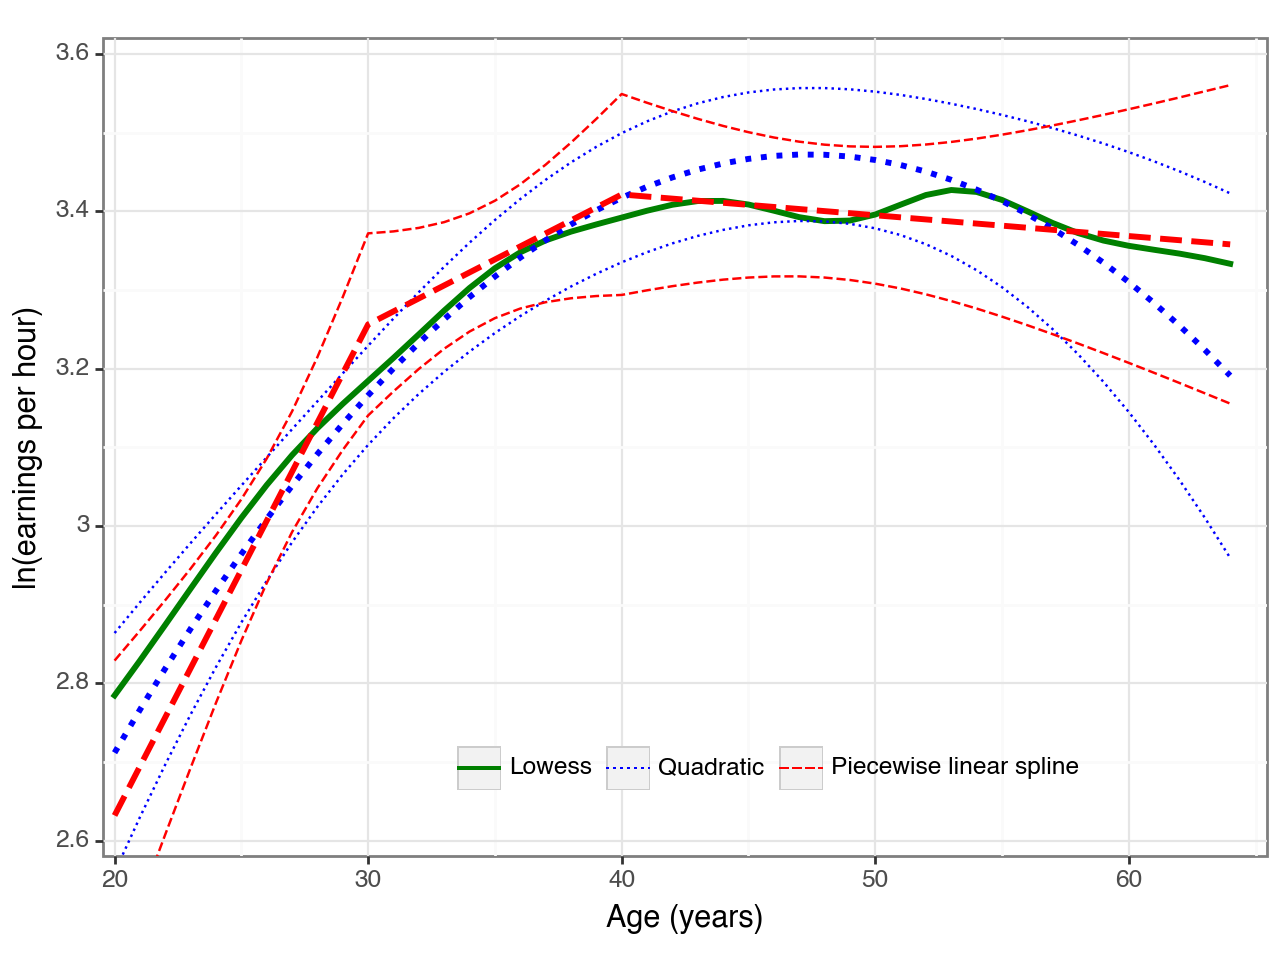

<Figure Size: (640 x 480)>

In [28]:
(
    ggplot(
        plotdata,
        aes(
            x="age",
            y="value",
            group="variable",
            color="estimate",
            linetype="estimate",
            size="CI",
        ),
    )
    + geom_line()
    + coord_cartesian(xlim=(20, 65), ylim=(2.6, 3.6))
    + scale_x_continuous(expand=(0.01, 0.01), limits=(20, 65))#, breaks=seq(20, 65, by=5))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(2.4, 3.6)#, breaks=seq(2.4, 3.6, by=0.20)
    )
    + labs(x="Age (years)", y="ln(earnings per hour)")
    + scale_color_manual(
        values=['green', 'blue', 'red'],
        labels=["Lowess", "Quadratic", "Piecewise linear spline"],
    )
    + scale_linetype_manual(
        values=["-", ":", "dashed"],
        labels=["Lowess", "Quadratic", "Piecewise linear spline"],
    )
    + scale_size_manual(values=(1.2, 0.5), guide=False)
    + theme_bw()
    + theme(
        legend_position=(0.6, 0.2),
        legend_direction="horizontal",
        legend_title=element_blank(),
        legend_background=element_blank(),
    )
)